In [34]:
import sys, os, datetime
sys.path.append("../../../")

from utils.contract_utils import init_contract
from utils.network_utils import configure_network_and_connect

import brownie

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style("whitegrid")

In [1]:
ALCHEMY_API_KEY = os.environ['ALCHEMY_API_KEY']
configure_network_and_connect(
    node_provider_https=f"https://eth-mainnet.alchemyapi.io/v2/{ALCHEMY_API_KEY}",
    network_name='mainnet'
)

NameError: name 'os' is not defined

In [37]:
tricrypto2_contract_addr = "0xD51a44d3FaE010294C616388b506AcdA1bfAAE46"
tricrypto2_contract = init_contract(tricrypto2_contract_addr)
tricrypto2_contract

<Vyper_contract Contract '0xD51a44d3FaE010294C616388b506AcdA1bfAAE46'>

In [38]:
tricrypto2_contract.price_oracle(0) * 1e-18

61544.61112139607

In [39]:
tricrypto2_lp_token_price_contract_address = "0xE8b2989276E2Ca8FDEA2268E3551b2b4B2418950"
contract_genesis = 12821148
tricrypto2_lp_token_price_contract = init_contract(tricrypto2_lp_token_price_contract_address)
tricrypto2_lp_token_price_contract

<Vyper_contract Contract '0xE8b2989276E2Ca8FDEA2268E3551b2b4B2418950'>

In [40]:
tricrypto2_lp_token_price_contract.lp_price() * 1e-18

1931.5880989927807

In [41]:
def get_lp_price_from_block(
    block_number_start: int,
    lp_price_contract: brownie.Contract,
    lp_contract: brownie.Contract,
    block_steps: int = 10000
) -> pd.DataFrame:

    current_block = brownie.web3.eth.block_number
    blocks_to_calculate = list(range(block_number_start, current_block, block_steps))
    blocks_to_calculate.append(current_block)

    data = {
        'timestamp': [],
        'block_number': [],
        'lp_token_price': [],
        'btc_price': [],
        'eth_price': [],
    }

    for block_number in blocks_to_calculate:

        block_details = brownie.web3.eth.get_block(block_number)
        block_time = datetime.datetime.fromtimestamp(block_details['timestamp'])
        btc_price = lp_contract.price_oracle(0, block_identifier=block_number) * 1e-18
        eth_price = lp_contract.price_oracle(1, block_identifier=block_number) * 1e-18

        try:
            lp_token_price = lp_price_contract.lp_price(block_identifier=block_number)
        except ValueError:  # lp_price contract doesn't exist yet smh
            lp_token_price = 0


        data['timestamp'].append(block_time)
        data['block_number'].append(block_number)
        data['lp_token_price'].append(lp_token_price)
        data['btc_price'].append(btc_price)
        data['eth_price'].append(eth_price)

    df_data = pd.DataFrame(data)

    return df_data.set_index('timestamp')

In [42]:
df_prices = get_lp_price_from_block(
    block_number_start=contract_genesis,
    lp_price_contract=tricrypto2_lp_token_price_contract,
    lp_contract=tricrypto2_contract,
    block_steps=5000
)
df_prices

,block_number,lp_token_price,btc_price,eth_price
timestamp,,,,
2021-07-13 23:18:03,12821148,0,32560.000000,1954.200000
2021-07-14 18:16:53,12826148,0,32947.254489,1986.459479
2021-07-15 13:00:45,12831148,0,32529.934944,1941.775939
2021-07-16 07:49:10,12836148,0,31979.371948,1945.184544
2021-07-17 02:40:00,12841148,0,31431.825044,1876.375989
...,...,...,...,...
2021-10-28 16:01:03,13506148,1909931865384916220825,60941.884480,4177.121428
2021-10-29 10:56:07,13511148,1928113884050299850015,60727.796944,4312.491351
2021-10-30 05:31:45,13516148,1947990699635436364102,61968.729544,4358.141660


In [43]:
df_prices.lp_token_price *= 1e-18
df_prices

,block_number,lp_token_price,btc_price,eth_price
timestamp,,,,
2021-07-13 23:18:03,12821148,0.0,32560.000000,1954.200000
2021-07-14 18:16:53,12826148,0.0,32947.254489,1986.459479
2021-07-15 13:00:45,12831148,0.0,32529.934944,1941.775939
2021-07-16 07:49:10,12836148,0.0,31979.371948,1945.184544
2021-07-17 02:40:00,12841148,0.0,31431.825044,1876.375989
...,...,...,...,...
2021-10-28 16:01:03,13506148,1909.931865,60941.884480,4177.121428
2021-10-29 10:56:07,13511148,1928.113884,60727.796944,4312.491351
2021-10-30 05:31:45,13516148,1947.9907,61968.729544,4358.141660


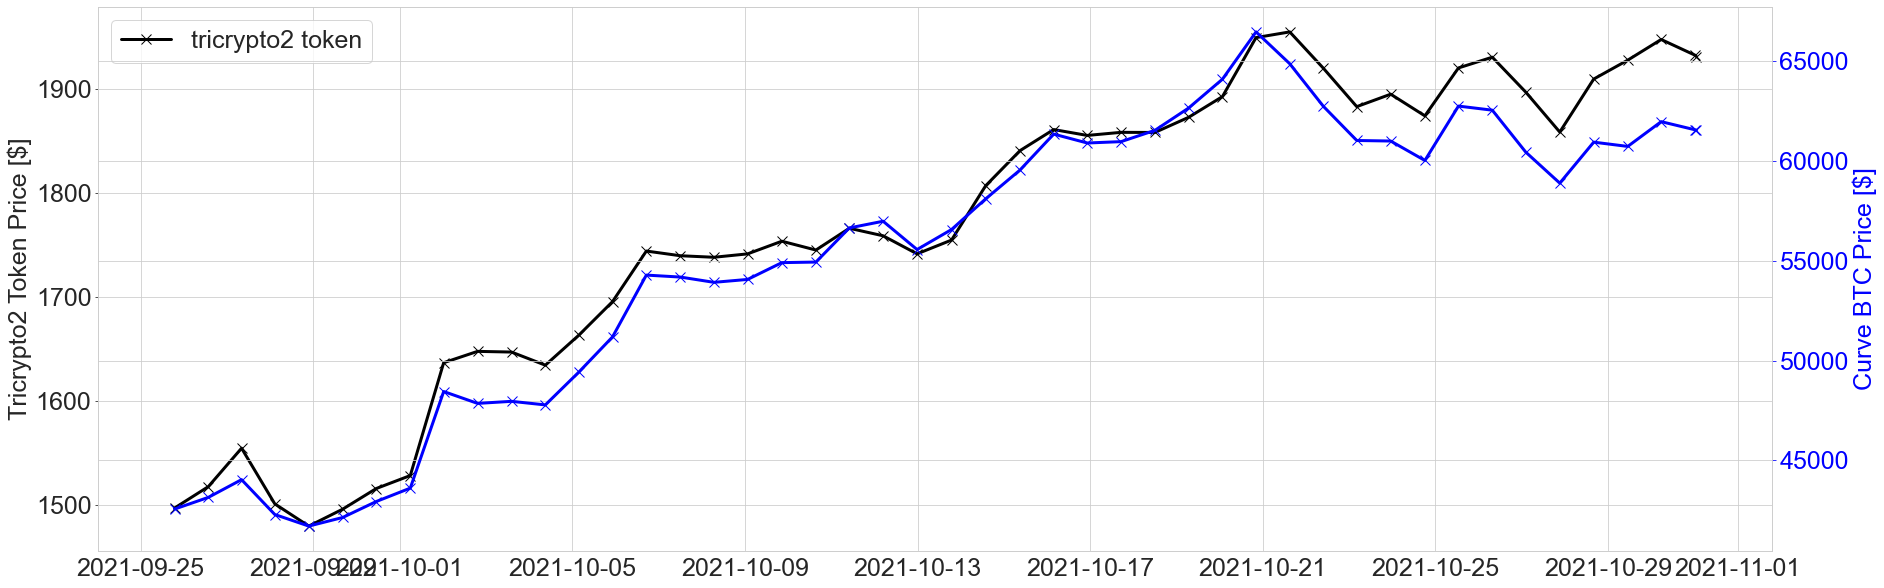

In [44]:
fig, ax = plt.subplots(1,1, figsize=(30, 10))

df_plot = df_prices.where(df_prices['lp_token_price'] > 0)

ax.plot(df_plot.index, df_plot.lp_token_price, 'kx-', lw=3, ms=10, label='tricrypto2 token')

ax.set_ylabel("")
ax.set_ylabel("Tricrypto2 Token Price [$]", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25);
ax.legend(fontsize=25);

ax2 = ax.twinx()
ax2.plot(df_plot.index, df_plot.btc_price, 'bx-', lw=3, ms=10, label='btc token')
ax2.set_ylabel("Curve BTC Price [$]", fontsize=25, color='blue')
ax2.tick_params(axis='both', which='major', labelsize=25, colors='blue');



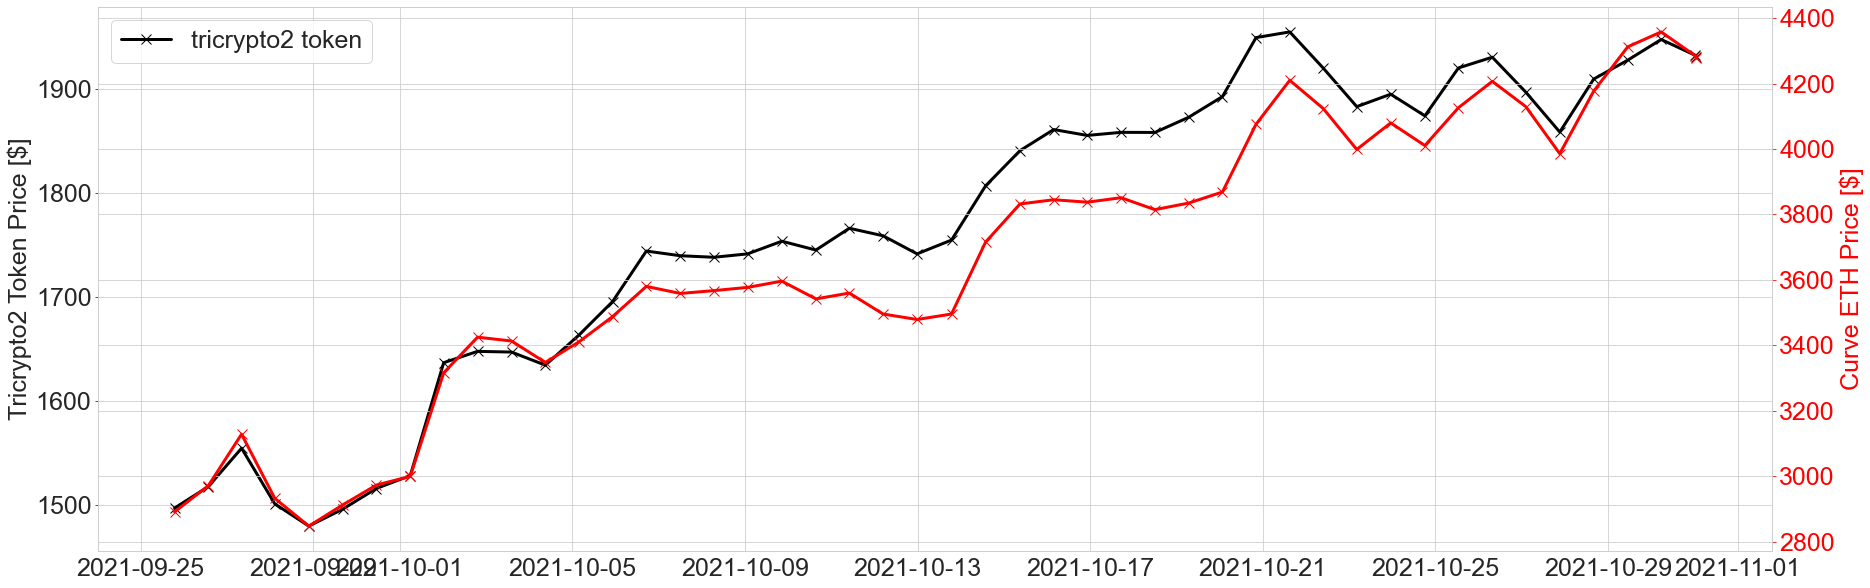

In [45]:
fig, ax = plt.subplots(1,1, figsize=(30, 10))

df_plot = df_prices.where(df_prices['lp_token_price'] > 0)

ax.plot(df_plot.index, df_plot.lp_token_price, 'kx-', lw=3, ms=10, label='tricrypto2 token')

ax.set_ylabel("")
ax.set_ylabel("Tricrypto2 Token Price [$]", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25);
ax.legend(fontsize=25);

ax2 = ax.twinx()
ax2.plot(df_plot.index, df_plot.eth_price, 'rx-', lw=3, ms=10, label='eth token')
ax2.set_ylabel("Curve ETH Price [$]", fontsize=25, color='red')
ax2.tick_params(axis='both', which='major', labelsize=25, colors='red');


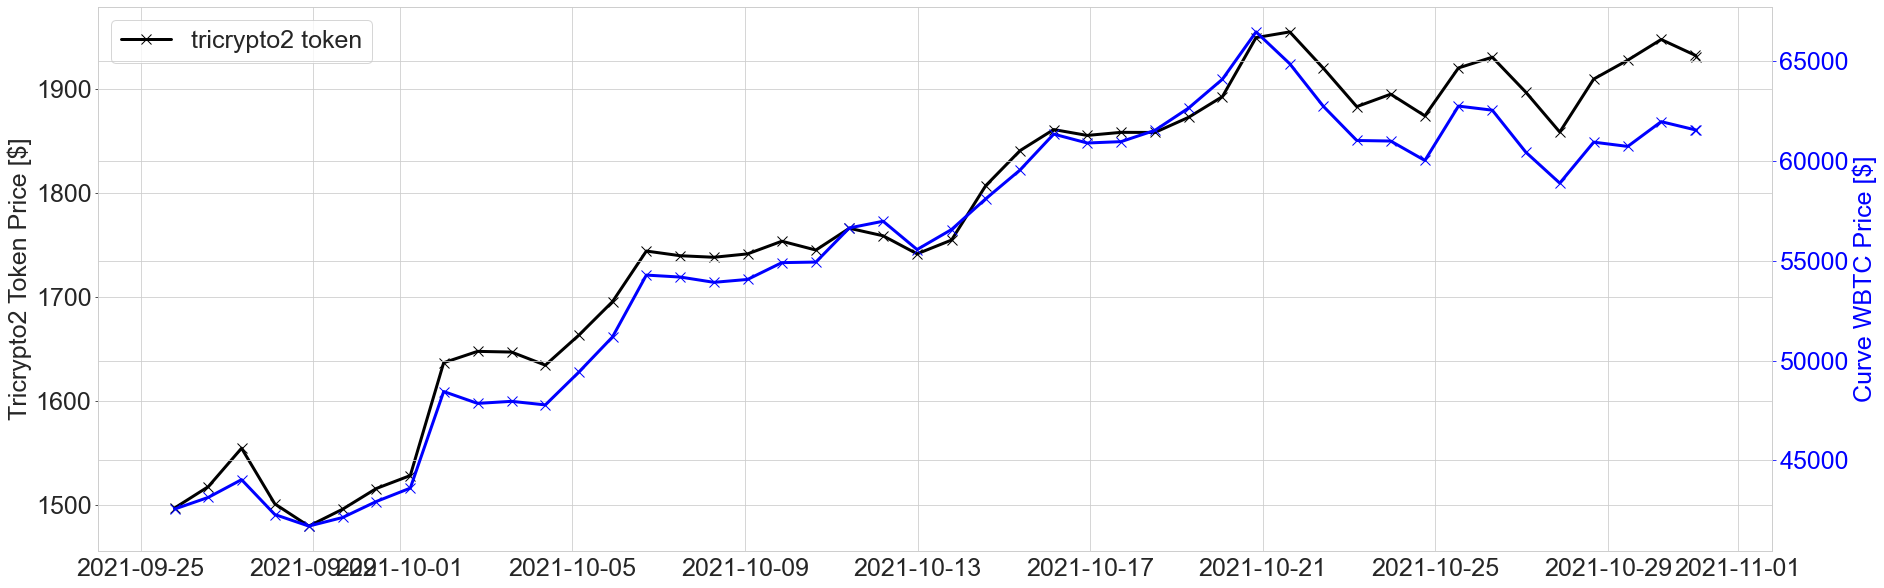

In [51]:
fig, ax = plt.subplots(1,1, figsize=(30, 10))

df_plot = df_prices.where(df_prices['lp_token_price'] > 0)
# df_plot['norm_btc'] = df_prices['btc_price']

ax.plot(df_plot.index, df_plot.lp_token_price, 'kx-', lw=3, ms=10, label='tricrypto2 token')

ax.set_ylabel("")
ax.set_ylabel("Tricrypto2 Token Price [$]", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25);
ax.legend(fontsize=25);

ax2 = ax.twinx()
ax2.plot(df_plot.index, df_plot.btc_price, 'bx-', lw=3, ms=10, label='wbtc token')
ax2.set_ylabel("Curve WBTC Price [$]", fontsize=25, color='blue')
ax2.tick_params(axis='both', which='major', labelsize=25, colors='blue');